In [ ]:
!git clone https://github.com/CBH2021/tcr-pmhc

Cloning into 'tcr-pmhc'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 337 (delta 16), reused 8 (delta 8), pack-reused 309
Receiving objects: 100% (337/337), 89.50 MiB | 37.21 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Checking out files: 100% (23/23), done.


In [ ]:
!pwd

/content


In [ ]:
%cd /content/tcr-pmhc/data

/content/tcr-pmhc/data


In [ ]:
!unzip train.zip

Archive:  train.zip
  inflating: P2_labels.npz           
   creating: __MACOSX/
  inflating: __MACOSX/._P2_labels.npz  
  inflating: P3_input.npz            
  inflating: __MACOSX/._P3_input.npz  
  inflating: P4_input.npz            
  inflating: __MACOSX/._P4_input.npz  
  inflating: P2_input.npz            
  inflating: __MACOSX/._P2_input.npz  
  inflating: P1_input.npz            
  inflating: __MACOSX/._P1_input.npz  
  inflating: P3_labels.npz           
  inflating: __MACOSX/._P3_labels.npz  
  inflating: P4_labels.npz           
  inflating: __MACOSX/._P4_labels.npz  
  inflating: P1_labels.npz           
  inflating: __MACOSX/._P1_labels.npz  


In [ ]:
%cd /content/

/content


In [ ]:
!rm -rf /content/models_save

In [ ]:
!mkdir /content/models_save

In [ ]:
### trying to print the model in keras style
#from torchsummary import summary

In [45]:
!pip install torchinfo

In [46]:
from torchinfo import summary

In [113]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=5fd7caa2b38beb87e2820a5000e5d10de769aabc3b90553691caf5e67215380b
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [ ]:
###### model starts from here

In [ ]:
#!/usr/bin/env python
# coding: utf-8
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters

## Model

In [ ]:
###############################
###    Load data            ###
###############################

data_list = []
target_list = []

import glob
for fp in glob.glob("/content/tcr-pmhc/data/*input.npz"):
    data = np.load(fp)["arr_0"]
    targets = np.load(fp.replace("input", "labels"))["arr_0"]
    
    data_list.append(data)
    target_list.append(targets)



##### might have to load data on GPU








In [ ]:

# Note:
# Choose your own training and val set based on data_list and target_list
# Here using the last partition as val set

#X_train = np.concatenate(data_list[0:])
#y_train = np.concatenate(target_list[0:]) #taking full data to train
X_train = np.concatenate(data_list[ :-1])
y_train = np.concatenate(target_list[:-1])
#X_train = np.concatenate(data_list[0,2,3])
#y_train = np.concatenate(target_list[0,2,3])
nsamples, nx, ny = X_train.shape
print("Training set shape:", nsamples,nx,ny)

X_val = np.concatenate(data_list[-1: ])
y_val = np.concatenate(target_list[-1: ])
#X_val = data_list[1]
#y_val = target_list[1]

#print(X_val.shape)
nsamples, nx, ny = X_val.shape
print("val set shape:", nsamples,nx,ny)

p_neg = len(y_train[y_train == 1])/len(y_train)*100
print("Percent positive samples in train:", p_neg)

p_pos = len(y_val[y_val == 1])/len(y_val)*100
print("Percent positive samples in val:", p_pos)

# make the data set into one dataset that can go into dataloader
train_ds = []
for i in range(len(X_train)):
    train_ds.append([np.transpose(X_train[i]), y_train[i]])

val_ds = []
for i in range(len(X_val)):
    val_ds.append([np.transpose(X_val[i]), y_val[i]])

bat_size = 128
print("\nNOTE:\nSetting batch-size to", bat_size)
train_ldr = torch.utils.data.DataLoader(train_ds,batch_size=bat_size, shuffle=True)
val_ldr = torch.utils.data.DataLoader(val_ds,batch_size=bat_size, shuffle=True)


# Set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("Using device (CPU/GPU):", device)
device = torch.device("cpu")


Training set shape: 4538 420 54
val set shape: 1168 420 54
Percent positive samples in train: 24.9669457910974
Percent positive samples in val: 25.0

NOTE:
Setting batch-size to 128


In [ ]:
print("Using device (CPU/GPU):", device)

Using device (CPU/GPU): cpu


In [116]:
try:
  del net
  import gc
  gc.collect()
except:
  pass

In [88]:
!rm -rf /content/models_save

In [89]:
!mkdir /content/models_save

In [ ]:
# ################################ THIS NETWORK WORKS GOOD- DO NOT EDIT
# ###############################
# ###    Define network       ###
# ###############################

# print("Initializing network")

# # Hyperparameters
# input_size = 420
# num_classes = 1
# learning_rate = 0.001 #0.0001

# class Net(nn.Module):
#     def __init__(self,  num_classes):
#         super(Net, self).__init__()
#         self.bn0 = nn.BatchNorm1d(54) ### edited after 4:30 PM       
#         self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv1.weight)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv1_bn = nn.BatchNorm1d(100)
        
#         self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv2.weight)
#         self.conv2_bn = nn.BatchNorm1d(100)
        
#         self.fc1 = nn.Linear(2600, num_classes)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        
#     def forward(self, x):
#         x = self.bn0(x)      ### edited after 4:30 PM   
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.conv1_bn(x)
        
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.conv2_bn(x)
        
#         x = x.view(x.size(0), -1)
#         #x = self.fc1(x)
#         x = torch.sigmoid(self.fc1(x))

        
#         return x
    
# # Initialize network
# net = Net(num_classes=num_classes).to(device)


# ## unbalanced loss
# #unbal_weight = torch.tensor([1,0.333]).to(device)

# # Loss and optimizer
# #criterion = nn.BCELoss()
# #criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate,
#                        weight_decay=0.003,
#                        amsgrad=True,
#                        ) 



# #optim.SGD(net.parameters(), lr=learning_rate)

In [117]:
################################ TRYING CNN LSTM HYBRID MODELS
###############################
###    Define network       ###
###############################

print("Initializing network")

# Hyperparameters
input_size = 420
num_classes = 1
learning_rate = 0.001 #0.0001

class Net(nn.Module):
    def __init__(self,  num_classes):
        super(Net, self).__init__()
        self.bn0 = nn.BatchNorm1d(54) ### edited after 4:30 PM       
        self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1_bn = nn.BatchNorm1d(100)
        
        self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv2_bn = nn.BatchNorm1d(100)
        
        ### try LSTM here

        self.rnn = nn.LSTM(input_size=100,hidden_size=26,num_layers=4, batch_first=True)
        #self.rnn = nn.GRU(input_size=100,hidden_size=26,num_layers=4, dropout=0.1, batch_first=True)

        ####################################

        self.fc1 = nn.Linear(676, num_classes)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
    def forward(self, x):
        x = self.bn0(x)      ### edited after 4:30 PM   
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv1_bn(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)

        x = x.transpose_(2, 1)
        #### lstm
        #x = x.transpose(1, 2).transpose(0, 1)


        #x, state = self.rnn(x)
        #print('size before rnn', x.size())
        
        x, (h, c) = self.rnn(x)
        #x, h = self.rnn(x)
        #x = x.transpose(0, 1).transpose(1, 2)
        ###
        #print(len(x))
        x = x.reshape(x.size(0), -1)
        #x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))

        
        return x
    
# Initialize network
net = Net(num_classes=num_classes).to(device)


## unbalanced loss
#unbal_weight = torch.tensor([1,0.333]).to(device)

# Loss and optimizer
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                       weight_decay=0.0005,
                       amsgrad=True,
                       ) 



#optim.SGD(net.parameters(), lr=learning_rate)

Initializing network


In [138]:
# summary(net, (54, 420))

In [92]:
#####weighted loss
def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        assert len(weights) == 2
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)
    return torch.neg(torch.mean(loss))

In [93]:
model_dir = '/content/models_save'

In [111]:
###############################
###         TRAIN           ###
###############################

print("Training")

num_epochs = 40

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
losses = []
val_losses = []

for epoch in range(num_epochs):
    cur_loss = 0
    val_loss = 0
    
    net.train()
    train_preds, train_targs = [], [] 
    for batch_idx, (data, target) in enumerate(train_ldr):
        X_batch =  data.float().detach().requires_grad_(True)
        target_batch = torch.tensor(np.array(target), dtype = torch.float).unsqueeze(1)
        
        optimizer.zero_grad()
        output = net(X_batch)
        

        batch_loss = weighted_binary_cross_entropy(output, target_batch, [0.75,0.25])
        #batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        preds = np.round(output.detach().cpu())
        train_targs += list(np.array(target_batch.cpu()))
        train_preds += list(preds.data.numpy().flatten())
        cur_loss += batch_loss.detach()

    losses.append(cur_loss / len(train_ldr.dataset))        
    
    net.eval()
    ### Evaluate validation
    val_preds, val_targs = [], []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_ldr): ###
            x_batch_val = data.float().detach()
            y_batch_val = target.float().detach().unsqueeze(1)
            
            output = net(x_batch_val)
            

            val_batch_loss = weighted_binary_cross_entropy(output, y_batch_val, [0.75,0.25])
            #val_batch_loss = criterion(output, y_batch_val)
            
            preds = np.round(output.detach())
            val_preds += list(preds.data.numpy().flatten()) 
            val_targs += list(np.array(y_batch_val))
            val_loss += val_batch_loss.detach()
            
        val_losses.append(val_loss / len(val_ldr.dataset))
        print("\nEpoch:", epoch+1)
        
        train_acc_cur = accuracy_score(train_targs, train_preds)  
        valid_acc_cur = accuracy_score(val_targs, val_preds) 

        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)
        
        from sklearn.metrics import matthews_corrcoef
        print("Training loss:", losses[-1].item(), "Validation loss:", val_losses[-1].item(), end = "\n")
        print("MCC Train:", matthews_corrcoef(train_targs, train_preds), "MCC val:", matthews_corrcoef(val_targs, val_preds))

        ##save model at every epoch
        torch.save(net.state_dict(), os.path.join(model_dir, 'model-epoch-{}.pt'.format(epoch)))
        print('Models saved at epoch', epoch+1)

Training

Epoch: 1
Training loss: 4.977096614311449e-05 Validation loss: 0.002204072894528508
MCC Train: 0.989407426426494 MCC val: 0.6135059354644901
Models saved at epoch 1

Epoch: 2
Training loss: 3.472793832770549e-05 Validation loss: 0.0019450861727818847
MCC Train: 0.9923467134013308 MCC val: 0.6187251285745443
Models saved at epoch 2

Epoch: 3
Training loss: 4.181106487521902e-05 Validation loss: 0.0024870389606803656
MCC Train: 0.9894005916442336 MCC val: 0.6138613512555139
Models saved at epoch 3

Epoch: 4
Training loss: 3.880061922245659e-05 Validation loss: 0.0020813802257180214
MCC Train: 0.988236516283237 MCC val: 0.6113224253568281
Models saved at epoch 4

Epoch: 5
Training loss: 8.874508057488129e-05 Validation loss: 0.0016896178713068366
MCC Train: 0.9728508880979576 MCC val: 0.642997965839795
Models saved at epoch 5

Epoch: 6
Training loss: 9.168387623503804e-05 Validation loss: 0.00212475354783237
MCC Train: 0.9699170759485831 MCC val: 0.5962757963947285
Models saved 

KeyboardInterrupt: ignored

## MH

Train accuracy:
[0.7091229616571176, 0.750330542089026, 0.750991626267078, 0.7765535478184222, 0.8237108858527986, 0.8561040105773469, 0.8664609960334949, 0.873071837814015, 0.8794623182018511, 0.8884971353018951, 0.8900396650506831, 0.9023799030409873, 0.8992948435434112, 0.8975319524019392, 0.9096518289995593, 0.9138386954605553, 0.9224327897752314, 0.9299250771264874, 0.9363155575143235, 0.9385191714411635, 0.9440282062582636, 0.9427060379021596, 0.9519612163948876, 0.9598942265315117, 0.9543851917144116, 0.9590127809607757, 0.9695901278096077, 0.9728955486998678, 0.9671661524900838, 0.9735566328779198, 0.9806081974438079, 0.9784045835169678, 0.9786249449096518, 0.9872190392243279, 0.988541207580432, 0.9907448215072719, 0.989863375936536, 0.989643014543852, 0.988320846187748, 0.9914059056853239]
Validation accuracy:
[0.75, 0.75, 0.7551369863013698, 0.7928082191780822, 0.8227739726027398, 0.8176369863013698, 0.833904109589041, 0.8467465753424658, 0.8561643835616438, 0.855308219178082

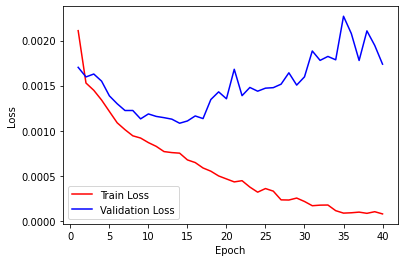

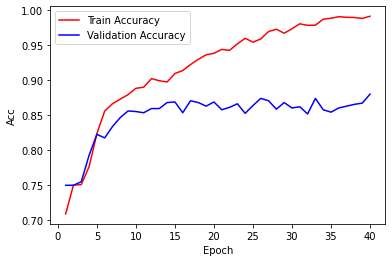

In [96]:
###############################
###        PERFORMANCE      ###
###############################

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, losses, 'r', epoch, val_losses, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

epoch = np.arange(1,len(train_acc)+1)
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

print("Train accuracy:", train_acc, sep = "\n")
print("Validation accuracy:", valid_acc, sep = "\n")


In [97]:
#### performance
from sklearn.metrics import matthews_corrcoef
print("MCC Train:", matthews_corrcoef(train_targs, train_preds))
print("MCC Test:", matthews_corrcoef(val_targs, val_preds))

print("Confusion matrix train:", confusion_matrix(train_targs, train_preds), sep = "\n")
print("Confusion matrix test:", confusion_matrix(val_targs, val_preds), sep = "\n")

MCC Train: 0.9769963924642375
MCC Test: 0.6631863385183814
Confusion matrix train:
[[3397    8]
 [  31 1102]]
Confusion matrix test:
[[839  37]
 [103 189]]


In [103]:
from sklearn.metrics import classification_report







'              precision    recall  f1-score   support\n\n         0.0       0.89      0.96      0.92       876\n         1.0       0.84      0.65      0.73       292\n\n    accuracy                           0.88      1168\n   macro avg       0.86      0.80      0.83      1168\nweighted avg       0.88      0.88      0.87      1168\n'

In [110]:
print('Training Classification Report')
print(classification_report(train_targs, train_preds))

Training Classification Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      3405
         1.0       0.99      0.97      0.98      1133

    accuracy                           0.99      4538
   macro avg       0.99      0.99      0.99      4538
weighted avg       0.99      0.99      0.99      4538



In [109]:
print('Validation Classification Report')
print(classification_report(val_targs, val_preds))

Validation Classification Report
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92       876
         1.0       0.84      0.65      0.73       292

    accuracy                           0.88      1168
   macro avg       0.86      0.80      0.83      1168
weighted avg       0.88      0.88      0.87      1168



In [105]:
def plot_roc(targets, predictions):
    # ROC
    fpr, tpr, threshold = metrics.roc_curve(targets, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # plot ROC
    plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    #plt.show()

Text(0.5, 1.0, 'Validation AUC')

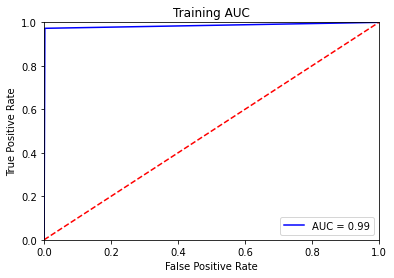

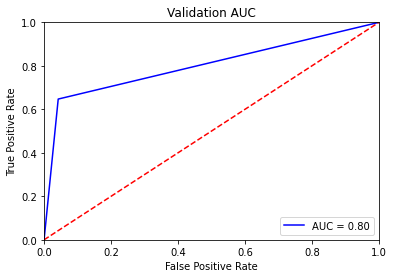

In [98]:
plot_roc(train_targs, train_preds)
plt.title("Training AUC")
plot_roc(val_targs, val_preds)
plt.title("Validation AUC")

In [114]:
from torchviz import make_dot

In [133]:
# Initialize network
net = Net(num_classes=num_classes).to(device)
x = torch.randn(1,54,420)
#y = model_see(x)

vis_graph = make_dot(net(x).mean(), params=dict(net.named_parameters()))
# vis_graph.view()

KeyboardInterrupt: ignored

In [136]:
from graphviz import Source; 
model_arch = make_dot(net(x).mean(), params=dict(net.named_parameters())); 
Source(model_arch).render('arch.png')

KeyboardInterrupt: ignored

In [137]:
from graphviz import Source
Source.from_file('/content/Digraph.gv')

KeyboardInterrupt: ignored

In [ ]:
make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz",

In [132]:
print(vis_graph)
#vis_graph.format = 'png'
#vis_graph.render("arch.png")

digraph {
	graph [size="561.15,561.15"]
	node [align=left fontname=monospace fontsize=10 height=0.2 ranksep=0.1 shape=box style=filled]
	139720133539712 [label="
 ()" fillcolor=darkolivegreen1]
	139720136060560 [label=MeanBackward0]
	139720136470736 -> 139720136060560
	139720136470736 [label=SigmoidBackward]
	139720133071376 -> 139720136470736
	139720133071376 [label=AddmmBackward]
	139720210747152 -> 139720133071376
	139720136651232 [label="fc1.bias
 (1)" fillcolor=lightblue]
	139720136651232 -> 139720210747152
	139720210747152 [label=AccumulateGrad]
	139720210746448 -> 139720133071376
	139720210746448 [label=ViewBackward]
	139720136239440 -> 139720210746448
	139720136239440 [label=TransposeBackward0]
	139720133349968 -> 139720136239440
	139720133349968 [label=StackBackward]
	139720135792272 -> 139720133349968
	139720135792272 [label=MulBackward0]
	139720131488784 -> 139720135792272
	139720131488784 [label=SigmoidBackward]
	139720131488976 -> 139720131488784
	139720131488976 [label=Un

In [ ]:
#model save below
# Write model to disk for use in predict.py
print("Saving model to src/model.pt")
torch.save(net.state_dict(), "/content/tcr-pmhc/src/model.pt")

Saving model to src/model.pt


In [ ]:
#### download the zip
!zip -r /content/models.zip /content/models_save

  adding: content/models_save/ (stored 0%)
  adding: content/models_save/model-epoch-29.pt (deflated 9%)
  adding: content/models_save/model-epoch-14.pt (deflated 9%)
  adding: content/models_save/model-epoch-10.pt (deflated 9%)
  adding: content/models_save/model-epoch-18.pt (deflated 9%)
  adding: content/models_save/model-epoch-2.pt (deflated 10%)
  adding: content/models_save/model-epoch-30.pt (deflated 9%)
  adding: content/models_save/model-epoch-35.pt (deflated 9%)
  adding: content/models_save/model-epoch-5.pt (deflated 9%)
  adding: content/models_save/model-epoch-23.pt (deflated 9%)
  adding: content/models_save/model-epoch-13.pt (deflated 9%)
  adding: content/models_save/model-epoch-31.pt (deflated 9%)
  adding: content/models_save/model-epoch-0.pt (deflated 9%)
  adding: content/models_save/model-epoch-28.pt (deflated 9%)
  adding: content/models_save/model-epoch-20.pt (deflated 9%)
  adding: content/models_save/model-epoch-17.pt (deflated 9%)
  adding: content/models_save

# Helpful scripts

# Show dataset as copied dataframes with named features
The dataset is a 3D numpy array, of dimensions n_complexes x features x positions. This makes viewing the features for individual complexes or samples challenging. Below is a function which copies the entire dataset, and converts it into a list of DataFrames with named indices and columns, in order to make understanding the data easier.

NB: This list of dataframes are only copies, and will not be passable into the neural network architecture.

In [ ]:
pd.read_csv("/content/tcr-pmhc/data/example.csv")

A    C  ...   global_pmhc_fa_sol   global_pmhc_p_aa_pp
0    0.0  0.0  ...              -39.727                 0.481
1    0.0  0.0  ...              -39.727                 0.481
2    0.0  0.0  ...              -39.727                 0.481
3    0.0  0.0  ...              -39.727                 0.481
4    0.0  0.0  ...              -39.727                 0.481
..   ...  ...  ...                  ...                   ...
415  0.0  0.0  ...                0.000                 0.000
416  0.0  0.0  ...                0.000                 0.000
417  0.0  0.0  ...                0.000                 0.000
418  0.0  0.0  ...                0.000                 0.000
419  0.0  0.0  ...                0.000                 0.000

[420 rows x 54 columns]

In [ ]:
def copy_as_dataframes(dataset_X):
    """
    Returns list of DataFrames with named features from dataset_X,
    using example CSV file
    """
    df_raw = pd.read_csv("/content/tcr-pmhc/data/example.csv")
    return [pd.DataFrame(arr, columns = df_raw.columns) for arr in dataset_X]

named_dataframes = copy_as_dataframes(X_train)
print("Showing first complex as dataframe. Columns are positions and indices are calculated features")
named_dataframes[0]

Showing first complex as dataframe. Columns are positions and indices are calculated features


A    C  ...   global_pmhc_fa_sol   global_pmhc_p_aa_pp
0    0.0  0.0  ...              -40.566                 0.554
1    0.0  0.0  ...              -40.566                 0.554
2    0.0  0.0  ...              -40.566                 0.554
3    0.0  0.0  ...              -40.566                 0.554
4    0.0  0.0  ...              -40.566                 0.554
..   ...  ...  ...                  ...                   ...
415  0.0  0.0  ...                0.000                 0.000
416  0.0  0.0  ...                0.000                 0.000
417  0.0  0.0  ...                0.000                 0.000
418  0.0  0.0  ...                0.000                 0.000
419  0.0  0.0  ...                0.000                 0.000

[420 rows x 54 columns]

# View complex MHC, peptide and TCR alpha/beta sequences
You may want to view the one-hot encoded sequences as sequences in single-letter amino-acid format. The below function will return the TCR, peptide and MHC sequences for the dataset as 3 lists.

In [ ]:
def oneHot(residue):
    """
    Converts string sequence to one-hot encoding
    Example usage:
    seq = "GSHSMRY"
    oneHot(seq)
    """
    
    mapping = dict(zip("ACDEFGHIKLMNPQRSTVWY", range(20)))
    if residue in "ACDEFGHIKLMNPQRSTVWY":
        return np.eye(20)[mapping[residue]]
    else:
        return np.zeros(20)
def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    seq=''
    for i in range(len(encoding)):
        if np.max(encoding[i])>0:
            seq+=mapping[np.argmax(encoding[i])]
    return seq

def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190,0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame({"MHC":mhc_sequences, "peptide":pep_sequences,
                                 "tcr":tcr_sequences})
    return df_sequences

In [ ]:
complex_sequences = extract_sequences(X_val)
print("Showing MHC, peptide and TCR alpha/beta sequences for each complex")
complex_sequences

Showing MHC, peptide and TCR alpha/beta sequences for each complex


MHC  ...                                                tcr
0     GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  VEQHPSTLSVQEGDSAVIKCTYSDSASNYFPWYKQELGKGPQLIID...
1     GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  TQTQPGMFVQEKEAVTLDCTYDTSDPSYGLFWYKQPSSGEMIFLIY...
2     GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  QVEQSPQSLIILEGKNCTLQCNYTVSPFSNLRWYKQDTGRGPVSLT...
3     GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  QVEQSPPDLILQEGANSTLRCNFSDSVNNLQWFHQNPWGQLINLFY...
4     GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  QPSTVASSEGAVVEIFCNHSVSNAYNFFWYLHFPGCAPRLLVKGSK...
...                                                 ...  ...                                                ...
1527  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  EQSPQFLSIQEGENLTVYCNSSSVFSSLQWYRQEPGEGPVLLVTVV...
1528  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  QSVTQLGSHVSVSEGALVLLRCNYSSSVPPYLFWYVQYPNQGLQLL...
1529  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  VQEGEDFTTYCNSSTTLSNIQWYKQRPGGHPVFLIQLVKSGEVKKK...
1530  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  VQEGEDFTTYCNSSTTLSNIQWYKQRPGGHPVFLIQLVKSGEVKKK...
1531  GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...  ...  QSVTQLGSHVSVSEGALVLLRCNYSSSVPPYLFWYVQYPNQGLQLL...

[1532 rows x 3 columns]

In [ ]:
### backup of convnet
# ################################ THIS NETWORK WORKS GOOD- DO NOT EDIT
# ###############################
# ###    Define network       ###
# ###############################

# print("Initializing network")

# # Hyperparameters
# input_size = 420
# num_classes = 1
# learning_rate = 0.001 #0.0001

# class Net(nn.Module):
#     def __init__(self,  num_classes):
#         super(Net, self).__init__()
#         self.bn0 = nn.BatchNorm1d(54) ### edited after 4:30 PM       
#         self.conv1 = nn.Conv1d(in_channels=54, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv1.weight)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv1_bn = nn.BatchNorm1d(100)
        
#         self.conv2 = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=3, stride=2, padding=1)
#         torch.nn.init.kaiming_uniform_(self.conv2.weight)
#         self.conv2_bn = nn.BatchNorm1d(100)
        
#         self.fc1 = nn.Linear(2600, num_classes)
#         torch.nn.init.xavier_uniform_(self.fc1.weight)
        
#     def forward(self, x):
#         x = self.bn0(x)      ### edited after 4:30 PM   
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.conv1_bn(x)
        
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.conv2_bn(x)
        
#         x = x.view(x.size(0), -1)
#         #x = self.fc1(x)
#         x = torch.sigmoid(self.fc1(x))

        
#         return x
    
# # Initialize network
# net = Net(num_classes=num_classes).to(device)


# ## unbalanced loss
# #unbal_weight = torch.tensor([1,0.333]).to(device)

# # Loss and optimizer
# #criterion = nn.BCELoss()
# #criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(net.parameters(), lr=learning_rate,
#                        weight_decay=0.003,
#                        amsgrad=True,
#                        ) 



# #optim.SGD(net.parameters(), lr=learning_rate)